# Foreword & Remarks

- This work was adapted from the 1st place solution of the Jigsaw 2020 competition: https://www.kaggle.com/rafiko1/1st-place-jigsaw-post-processing-example
- First place post-processing details can be found at: https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/160862. Main idea was to track the delta of predictions for each sample using successful submissions, then averaging them and 'pushing' the predictions in the same direction.
- I only configured it a little bit so that it can be used in this competition
- This notebook uses **only public notebook submission files**!! For me, using my ensemble as the "best sub" with minor tweaks to give a small boost in LB
- Since we are allowed to make 3 final submissions, if you are willing to risk it, feel free to have a submission that uses this pipeline

# Update Log

- **Version 6**: As per Chris' feedback, submisison dataframes are now sorted before their predictions are concatenated to the test dataframe. Also changed a public sub to another one as the submission could no longer be extracted. 

# Imports

In [8]:
# General imports
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [9]:
WEIGHT = 1 # best to keep between 1 and 2 from the orignal authors

In [10]:
submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
sub_best = pd.read_csv('sub_pp14.csv')#9632

In [11]:
files_sub = [
    'sub_9619.csv',#9619
    'sub_9603.csv',#9603
    'sub_9581.csv',#9581
    'sub_9577.csv',#9577
    '9557plusmeta.csv',#9559'
    'sub_mean_maybe9533.csv',#9533
    'ensembled_9527.csv',#9527
    'sub_minmax_9526.csv',#9526
    'sub_9512.csv',#9512
    'sub_maybe_0.9504.csv',#9504
    'sub_mixup7.csv',#9499
    'sub_9498.csv',#9498
    'sub_9486.csv',#9486
    'sub_768b5_5.csv',#9471
    'sub_512b6_3.csv',#9468
    'minmax3.csv',#9465
    
    'submission_median.csv',#9445
    'minmax7.csv',#9438
    'minmax2.csv',#9429
    'sub_b5new_2_.csv',#9426
    'mean_ensemble_b0-b5_256.csv',#9425
    'trashtry.csv',#9423
    'minmax5.csv',#9422
    'sub_512b4_2.csv',#9422
    'sub_384b5_2.csv',#9420
    'sub_blended_0.9418.csv',#9418

    'minmax1.csv',#9414
    'stack3.csv',#9369
    'stacknew1.csv',#9366
    'sub_b4new_1up_.csv',#9364
    'stack2.csv',#9364
    'sub_b2new_1_.csv',#9364
    'IMG_SZ_384_2018.csv',#9350
    'stack1.csv',#9349
    
    # '../input/submission-exploration/submission.csv',
    # '../input/rc-fork-siim-isic-melanoma-384x384/sub_EfficientNetB2_384.csv',
    # '../input/train-cv/submission.csv',
    # '../input/triple-stratified-kfold-with-tfrecords/submission.csv',
    # '../input/rank-then-blend/blend_sub.csv',
    'sub_pp14.csv'
]
files_sub = sorted(files_sub)
print(len(files_sub))
files_sub

35


['9557plusmeta.csv',
 'IMG_SZ_384_2018.csv',
 'ensembled_9527.csv',
 'mean_ensemble_b0-b5_256.csv',
 'minmax1.csv',
 'minmax2.csv',
 'minmax3.csv',
 'minmax5.csv',
 'minmax7.csv',
 'stack1.csv',
 'stack2.csv',
 'stack3.csv',
 'stacknew1.csv',
 'sub_384b5_2.csv',
 'sub_512b4_2.csv',
 'sub_512b6_3.csv',
 'sub_768b5_5.csv',
 'sub_9486.csv',
 'sub_9498.csv',
 'sub_9512.csv',
 'sub_9577.csv',
 'sub_9581.csv',
 'sub_9603.csv',
 'sub_9619.csv',
 'sub_b2new_1_.csv',
 'sub_b4new_1up_.csv',
 'sub_b5new_2_.csv',
 'sub_blended_0.9418.csv',
 'sub_maybe_0.9504.csv',
 'sub_mean_maybe9533.csv',
 'sub_minmax_9526.csv',
 'sub_mixup7.csv',
 'sub_pp14.csv',
 'submission_median.csv',
 'trashtry.csv']

In [12]:
for file in files_sub:
    test[file.replace(".csv", "")] = pd.read_csv(file).sort_values('image_name')["target"]
test['id'] = test.index

In [13]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,9557plusmeta,IMG_SZ_384_2018,ensembled_9527,mean_ensemble_b0-b5_256,minmax1,minmax2,minmax3,minmax5,minmax7,stack1,stack2,stack3,stacknew1,sub_384b5_2,sub_512b4_2,sub_512b6_3,sub_768b5_5,sub_9486,sub_9498,sub_9512,sub_9577,sub_9581,sub_9603,sub_9619,sub_b2new_1_,sub_b4new_1up_,sub_b5new_2_,sub_blended_0.9418,sub_maybe_0.9504,sub_mean_maybe9533,sub_minmax_9526,sub_mixup7,sub_pp14,submission_median,trashtry,id
0,ISIC_0052060,IP_3579794,male,70.0,NaN,0.027383,0.032299,0.027438,0.000309,0.000108,0.000108,0.000296,0.000425,0.000166,0.008034,0.008002,0.003161,0.008648,0.024640,0.028950,0.028757,0.027959,0.465825,0.035619,0.000021,0.035168,0.031921,0.012047,0.022257,0.000597,0.000108,0.000166,0.034647,0.000153,0.022257,0.026612,0.028119,0.037576,0.036479,0.001561,0
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,0.024670,0.028524,0.026074,0.000159,0.000020,0.000020,0.000020,0.000020,0.000020,0.007987,0.007918,0.003162,0.008760,0.020853,0.025464,0.025109,0.025673,0.193438,0.030290,0.000013,0.026585,0.025793,0.009849,0.016384,0.000417,0.000020,0.000068,0.029409,0.000118,0.016384,0.023487,0.023260,0.030450,0.023535,0.000427,1
2,ISIC_0058510,IP_7960270,female,55.0,torso,0.024656,0.027188,0.025925,0.000186,0.000072,0.000072,0.000072,0.000072,0.000072,0.007957,0.007847,0.003165,0.008500,0.027445,0.023276,0.029317,0.021880,0.001455,0.020130,0.000281,0.028502,0.027990,0.012835,0.023354,0.000396,0.000133,0.000124,0.023827,0.002049,0.023354,0.023767,0.023901,0.037198,0.031711,0.000575,2
3,ISIC_0073313,IP_6375035,female,50.0,torso,0.023767,0.027435,0.026442,0.000192,0.000053,0.000053,0.000053,0.000053,0.000053,0.007963,0.007866,0.003166,0.009011,0.022915,0.025389,0.029134,0.023915,0.000135,0.021280,0.000015,0.030733,0.030547,0.010287,0.017497,0.000466,0.000053,0.000195,0.024287,0.000135,0.017497,0.024287,0.022620,0.037297,0.026989,0.000598,3
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0.023220,0.031915,0.033966,0.000948,0.000886,0.000527,0.001274,0.000527,0.002020,0.008137,0.008166,0.003206,0.008412,0.025112,0.027554,0.030768,0.031367,0.572050,0.161430,0.000044,0.032410,0.027750,0.011848,0.018092,0.002193,0.000216,0.002020,0.031621,0.000448,0.018092,0.027824,0.029094,0.029758,0.024709,0.002264,4


In [14]:
test.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', '9557plusmeta', 'IMG_SZ_384_2018',
       'ensembled_9527', 'mean_ensemble_b0-b5_256', 'minmax1', 'minmax2',
       'minmax3', 'minmax5', 'minmax7', 'stack1', 'stack2', 'stack3',
       'stacknew1', 'sub_384b5_2', 'sub_512b4_2', 'sub_512b6_3', 'sub_768b5_5',
       'sub_9486', 'sub_9498', 'sub_9512', 'sub_9577', 'sub_9581', 'sub_9603',
       'sub_9619', 'sub_b2new_1_', 'sub_b4new_1up_', 'sub_b5new_2_',
       'sub_blended_0.9418', 'sub_maybe_0.9504', 'sub_mean_maybe9533',
       'sub_minmax_9526', 'sub_mixup7', 'sub_pp14', 'submission_median',
       'trashtry', 'id'],
      dtype='object')

In [15]:
# # Derive the given sub increases or decreases in score
# test["diff_good1"] =  test['../input/rank-then-blend/blend_sub'] - test['../input/triple-stratified-kfold-with-tfrecords/submission']
# test["diff_good1"] =  test['../input/train-cv/submission'] - test['../input/siim-isic-melanoma-classification-ensemble/submission']
# test["diff_good2"] = test['../input/rc-fork-siim-isic-melanoma-384x384/sub_EfficientNetB2_384'] - test['../input/submission-exploration/submission']
# test["diff_good3"] = test['../input/analysis-of-melanoma-metadata-and-effnet-ensemble/ensembled'] - test['../input/new-basline-np-log2-ensemble-top-10/submission']

# test["diff_bad1"] = test['../input/stacking-ensemble-on-my-submissions/submission_mean'] - test['../input/minmax-ensemble-0-9526-lb/submission']

In [16]:
# Derive the given sub increases or decreases in score
test["diff_good0"] =  test['sub_9619'] - test['sub_9603'] 
test["diff_good1"] =  test['sub_9581'] - test['sub_9577'] 
test["diff_good2"] =  test['9557plusmeta'] - test['sub_mean_maybe9533'] 
test["diff_good3"] =  test['ensembled_9527'] - test['sub_minmax_9526']
test["diff_good4"] =  test['sub_9512'] - test['sub_maybe_0.9504']
test["diff_good5"] =  test['sub_mixup7'] - test['sub_9498']

test["diff_good6"] =  test['sub_9498'] - test['sub_9486']
test["diff_good7"] =  test['sub_768b5_5'] - test['sub_512b6_3']
test["diff_good8"] =  test['sub_512b6_3'] - test['minmax3']
test["diff_good9"] =  test['submission_median'] - test['minmax7']
test["diff_good10"] =  test['minmax2'] - test['sub_b5new_2_']
test["diff_good11"] =  test['mean_ensemble_b0-b5_256'] - test['trashtry']
test["diff_good12"] =  test['minmax5'] - test['sub_512b4_2']
test["diff_good13"] =  test['sub_384b5_2'] - test['sub_blended_0.9418']

test["diff_good14"] =  test['minmax1'] - test['stack3']
test["diff_good15"] =  test['stacknew1'] - test['sub_b4new_1up_']
test["diff_good16"] =  test['stack2'] - test['sub_b2new_1_']
test["diff_good17"] =  test['IMG_SZ_384_2018'] - test['stack1']

In [17]:
test["sub_best"] = test['sub_pp14']
col_comment = ["id", "image_name", "patient_id", "sub_best"]
col_diff = [column for column in test.columns if "diff" in column]
test_diff = test[col_comment + col_diff].reset_index(drop=True)

test_diff["diff_avg"] = test_diff[col_diff].mean(axis=1) # the mean trend

In [18]:
# Apply the post-processing technique in one line (as explained in the pseudo-code of my post.
test_diff["sub_new"] = test_diff.apply(lambda x: (1+WEIGHT*x["diff_avg"])*x["sub_best"] if x["diff_avg"]<0 else (1-WEIGHT*x["diff_avg"])*x["sub_best"] + WEIGHT*x["diff_avg"] , axis=1)

In [19]:
submission["target"] = sub_best["target"]
submission.head()

,image_name,target
0,ISIC_0052060,0.037576
1,ISIC_0052349,0.030450
2,ISIC_0058510,0.037198
3,ISIC_0073313,0.037297
4,ISIC_0073502,0.029758


In [20]:
test_diff.head()

,id,image_name,patient_id,sub_best,diff_good0,diff_good1,diff_good2,diff_good3,diff_good4,diff_good5,diff_good6,diff_good7,diff_good8,diff_good9,diff_good10,diff_good11,diff_good12,diff_good13,diff_good14,diff_good15,diff_good16,diff_good17,diff_avg,sub_new
0,0,ISIC_0052060,IP_3579794,0.037576,0.010210,-0.003247,0.005126,0.000826,-0.000132,-0.007500,-0.430206,-0.000798,0.028462,0.036313,-0.000059,-0.001251,-0.028525,-0.010007,-0.003053,0.008540,0.007405,0.024264,-0.020202,0.036817
1,1,ISIC_0052349,IP_7782715,0.030450,0.006535,-0.000791,0.008286,0.002588,-0.000105,-0.007031,-0.163148,0.000563,0.025089,0.023515,-0.000048,-0.000268,-0.025444,-0.008556,-0.003141,0.008740,0.007501,0.020536,-0.005843,0.030272
2,2,ISIC_0058510,IP_7960270,0.037198,0.010519,-0.000513,0.001302,0.002158,-0.001768,0.003771,0.018675,-0.007437,0.029246,0.031639,-0.000053,-0.000389,-0.023205,0.003618,-0.003093,0.008367,0.007451,0.019231,0.005529,0.042521
3,3,ISIC_0073313,IP_6375035,0.037297,0.007210,-0.000186,0.006270,0.002155,-0.000120,0.001340,0.021145,-0.005219,0.029081,0.026936,-0.000143,-0.000406,-0.025336,-0.001372,-0.003114,0.008958,0.007400,0.019472,0.005226,0.042328
4,4,ISIC_0073502,IP_0589375,0.029758,0.006244,-0.004660,0.005128,0.006143,-0.000404,-0.132336,-0.410620,0.000599,0.029494,0.022689,-0.001493,-0.001317,-0.027027,-0.006508,-0.002319,0.008197,0.005973,0.023777,-0.026580,0.028967


In [21]:
submission.loc[test["id"], "target"] = test_diff["sub_new"].values

In [22]:
submission.to_csv("sub_pp15.csv", index=False)
submission.head()

,image_name,target
0,ISIC_0052060,0.036817
1,ISIC_0052349,0.030272
2,ISIC_0058510,0.042521
3,ISIC_0073313,0.042328
4,ISIC_0073502,0.028967


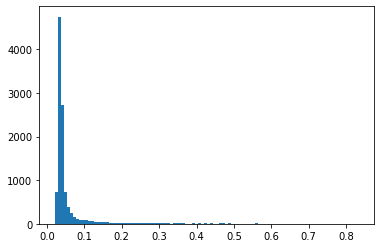

In [23]:
plt.hist(submission.target,bins=100)
plt.show()